In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
# from tensorflow.keras.models import clone_model

### Specifying data directory and epochs

In [2]:
data_dir = Path("./datasets/captcha_images_v2/")
data_dir2 = Path("./datasets/dataset/")
#data_dir3 = Path("./datasets/captcha_breaker")

model_dir = Path("base_model/saved_model")

d1_epochs = 100 # Change from 30
d2_epochs = 40 # Changed from 20
#d3_epochs = 20

# Something about CTC? 

In [3]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

# Class structure for handling the datasets

In [4]:
class DataSetHandler():
    def __init__(self,  data_dir,  img_size = (200, 50)):
        pass
        
    def init_calculations(self):
        pass
        
    def print_basics(self):
        pass
    
    # def split_data(images, labels, train_size=0.9, shuffle=True):
    def split_data(self, train_size=0.9, shuffle=True):
        pass

    def encode_single_sample(self, img_path, label):
        pass

    def process_dataset(self, invert_color = False):
        pass

    def plot_examples(self):
        pass
        
    def build_model(self):
        pass
    
    def train_model(self, epochs = 10, early_stopping_patience = 10):
        pass
        
    def make_predictions(self):
        pass


# Dataset 1

In [5]:
def init(self, data_dir,  img_size = (200, 50), file_name_excluder = ""):
    self.img_width = img_size[0]
    self.img_height = img_size[1]
    self.data_dir = data_dir;
    
    self.invert_color = False
    self.batch_size = 16
    self.downsample_factor = 4
    self.init_calculations(file_name_excluder)

# explain yada yada
def init_calculations(self, file_name_excluder):
    
    self.images = sorted(list(map(str, list(self.data_dir.glob("*.png")))))
    self.labels = [img.split(os.path.sep)[-1].split(file_name_excluder + ".png")[0] for img in self.images]
    
    self.max_length = max([len(label) for label in self.labels])
    
    characters = set(char for label in self.labels for char in label)
    self.characters = sorted(list(characters))

    self.char_to_num = layers.StringLookup(
        vocabulary=list(self.characters), mask_token=None
    )
        
    # Mapping integers back to original characters
    self.num_to_char = layers.StringLookup(
        vocabulary=self.char_to_num.get_vocabulary(), mask_token=None, invert=True
    )

DataSetHandler.__init__ = init
DataSetHandler.init_calculations = init_calculations

data1 = DataSetHandler(data_dir = data_dir)

In [6]:
# explain
def print_basics(self):
    print("Number of images found: ", len(self.images))
    print("Number of labels found: ", len(self.labels))
    print("Number of unique characters: ", len(self.characters))
    print("Characters present: ", self.characters)    
    
DataSetHandler.print_basics = print_basics

data1.print_basics()

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


## Splitting data

In [24]:
def split_data(self, train_size=0.7, test_size=0.15, validation_size=0.15, shuffle=True):
    if train_size + test_size + validation_size != 1.0:
        raise ValueError("Sum of train_size, test_size, and validation_size should be equal to 1.0")

    # Shuffle the data if required
    indices = np.arange(len(self.images))
    if shuffle:
        np.random.shuffle(indices)

    # Split indices for train, validation, and test
    train_end = int(len(indices) * train_size)
    test_end = train_end + int(len(indices) * test_size)

    train_indices = indices[:train_end]
    test_indices = indices[train_end:test_end]
    validation_indices = indices[test_end:]

    # Split the data
    self.x_train, self.y_train = np.array(self.images)[train_indices], np.array(self.labels)[train_indices]
    self.x_test, self.y_test = np.array(self.images)[test_indices], np.array(self.labels)[test_indices]
    self.x_valid, self.y_valid = np.array(self.images)[validation_indices], np.array(self.labels)[validation_indices]

    return self.x_train, self.x_valid, self.x_test, self.y_train, self.y_valid, self.y_test

DataSetHandler.split_data = split_data

data1.split_data();

In [8]:
# Function to print the sizes of the datasets
def print_dataset_sizes(handler):
    print("Training Set Size:", len(handler.x_train))
    print("Validation Set Size:", len(handler.x_valid))
    print("Test Set Size:", len(handler.x_test))
    print("Total Size:", len(handler.x_train) + len(handler.x_valid) + len(handler.x_test))

# Split data on data1
data1.split_data()  # Split the data using the chosen method
print_dataset_sizes(data1)  # Print the sizes of each dataset

Training Set Size: 728
Validation Set Size: 156
Test Set Size: 156
Total Size: 1040


## Data preprocessing

In [9]:
def encode_single_sample(self, img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [self.img_height, self.img_width])
    
    if (self.invert_color):
        # Inverting color
        img = 1- img
    
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = self.char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

DataSetHandler.encode_single_sample = encode_single_sample

In [10]:
def process_dataset(self, invert_color = False):
    self.invert_color = invert_color
    train_dataset = tf.data.Dataset.from_tensor_slices((self.x_train, self.y_train))
    self.train_dataset = (
        train_dataset.map(
            # self.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
            self.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(self.batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    validation_dataset = tf.data.Dataset.from_tensor_slices((self.x_valid, self.y_valid))
    self.validation_dataset = (
        validation_dataset.map(
            self.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(self.batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    
    test_dataset = tf.data.Dataset.from_tensor_slices((self.x_test, self.y_test))
    self.test_dataset = (
        test_dataset.map(
            self.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(self.batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    
    return (self.train_dataset, self.validation_dataset, self.test_dataset)

DataSetHandler.process_dataset = process_dataset

data1.process_dataset();

## plotting examples

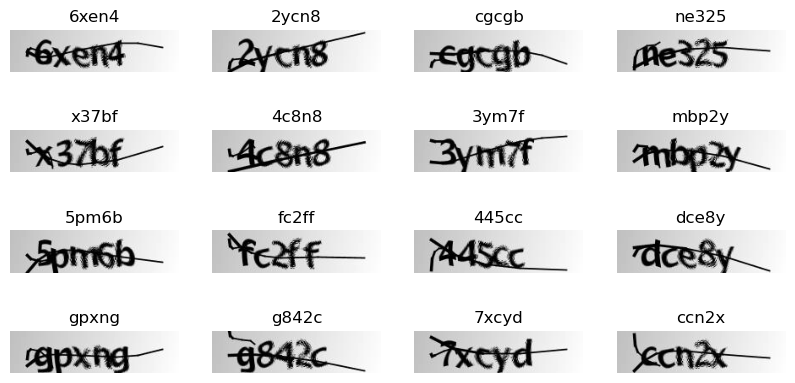

In [11]:
def plot_examples(self):
    _, ax = plt.subplots(4, 4, figsize=(10, 5))
    for batch in self.train_dataset.take(1):
        images = batch["image"]
        labels = batch["label"]
        for i in range(16):
            img = (images[i] * 255).numpy().astype("uint8")
            label = tf.strings.reduce_join(self.num_to_char(labels[i])).numpy().decode("utf-8")
            ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
            ax[i // 4, i % 4].set_title(label)
            ax[i // 4, i % 4].axis("off")
    plt.show()
    
DataSetHandler.plot_examples = plot_examples

data1.plot_examples()

## Defining a base model for the first dataset

In [12]:
def base_model_1(dataset_handler):
    # Inputs to the model
    input_img = layers.Input(
        shape=(dataset_handler.img_width, dataset_handler.img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((dataset_handler.img_width // 4), (dataset_handler.img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25), name = "bidirectional1")(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25, name = "bidirectional2"))(x)

    # Output layer
    x = layers.Dense(
        len(dataset_handler.char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
        # 50, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    dataset_handler.model = model
    return model

In [13]:
# data1.build_model = base_model_1
# model1 = data1.build_model(data1);
model1 = base_model_1(data1)
model1.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

## training model

In [14]:
def train_model(self, epochs = 10, early_stopping_patience = 10, model = None):
    # epochs = 10
    # early_stopping_patience = 10
    # Add early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
    )

    # Allowing to change on a model not defined for the dataset
    if (model):
        model_to_fit = model
    else: 
        model_to_fit = self.model
        
    
    # Train the model
    self.history = model_to_fit.fit(
        self.train_dataset,
        validation_data=self.validation_dataset,
        epochs=epochs,
        callbacks=[early_stopping],
    )

DataSetHandler.train_model = train_model

data1.train_model(epochs = d1_epochs)
# data1.train_model(epochs = 30)

Epoch 1/100
46/46 [==============================] - 10s 124ms/step - loss: 24.1471 - val_loss: 16.3947
Epoch 2/100
46/46 [==============================] - 5s 98ms/step - loss: 16.3629 - val_loss: 16.3757
Epoch 3/100
46/46 [==============================] - 5s 99ms/step - loss: 16.3475 - val_loss: 16.3804
Epoch 4/100
46/46 [==============================] - 5s 100ms/step - loss: 16.3470 - val_loss: 16.3797
Epoch 5/100
46/46 [==============================] - 5s 100ms/step - loss: 16.3391 - val_loss: 16.3803
Epoch 6/100
46/46 [==============================] - 4s 97ms/step - loss: 16.3302 - val_loss: 16.3837
Epoch 7/100
46/46 [==============================] - 5s 98ms/step - loss: 16.3276 - val_loss: 16.3757
Epoch 8/100
46/46 [==============================] - 5s 103ms/step - loss: 16.3230 - val_loss: 16.3663
Epoch 9/100
46/46 [==============================] - 5s 100ms/step - loss: 16.3106 - val_loss: 16.3587
Epoch 10/100
46/46 [==============================] - 5s 100ms/step - loss: 

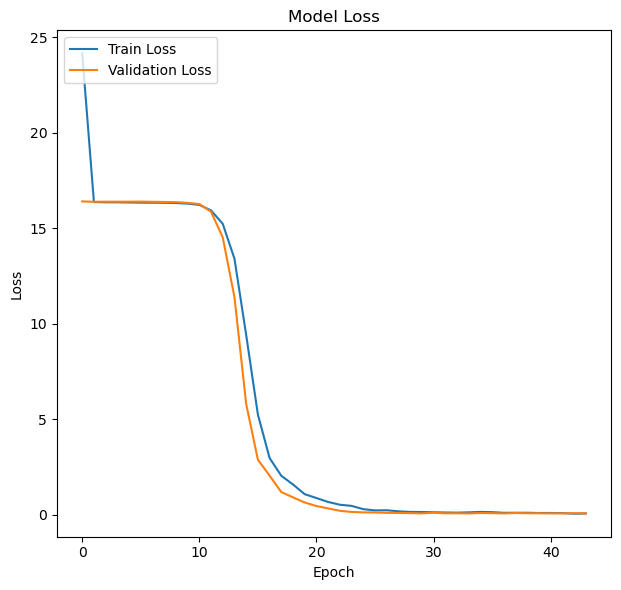

In [61]:
def plot_training_history(self):
    history = self.history.history

    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

DataSetHandler.plot_training_history = plot_training_history
data1.plot_training_history()

## Making predictions

1/1 [==============================] - 1s 884ms/step


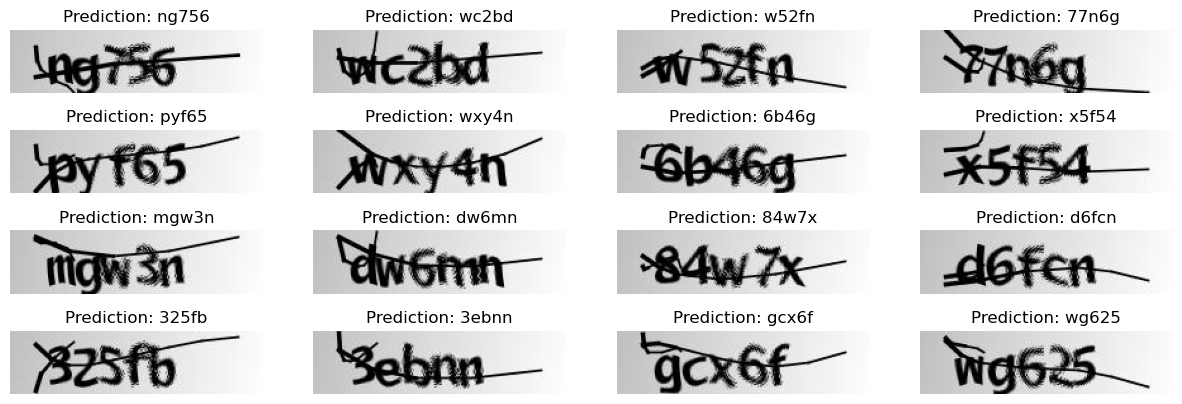

In [16]:
def make_predictions(self, model = None):
    
    if (model == None):
        _model = self.model
    else: 
        _model = model;
    # Get the prediction model by extracting layers till the output layer
    prediction_model = keras.models.Model(
        _model.get_layer(name="image").input, _model.get_layer(name="dense2").output
        # _model.get_layer(name="image").input, _model.get_layer(name="ctc_loss").output
    )
    # prediction_model.summary()

    # A utility function to decode the output of the network
    def decode_batch_predictions(pred):
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        
        # Use greedy search. For complex tasks, you can use beam search
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :self.max_length
        ]
        # Iterate over the results and get back the text
        output_text = []
        for res in results:
            res = tf.strings.reduce_join(self.num_to_char(res)).numpy().decode("utf-8")
            output_text.append(res)
        return output_text


    #  Let's check results on some validation samples
    for batch in self.test_dataset.take(1):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        orig_texts = []
        for label in batch_labels:
            label = tf.strings.reduce_join(self.num_to_char(label)).numpy().decode("utf-8")
            orig_texts.append(label)

        _, ax = plt.subplots(4, 4, figsize=(15, 5))
        for i in range(len(pred_texts)):
            img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
            img = img.T
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
    plt.show()
    
DataSetHandler.make_predictions = make_predictions

data1.make_predictions()

In [18]:
def evaluate_image_prediction_accuracy(self):
    correct_image_predictions = 0
    total_image_predictions = 0

    # A utility function to decode the output of the network
    def decode_batch_predictions(pred):
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :self.max_length]
        output_text = []
        for res in results:
            res = tf.strings.reduce_join(self.num_to_char(res)).numpy().decode("utf-8")
            output_text.append(res)
        return output_text

    # Create a prediction model similar to the one in make_predictions
    prediction_model = keras.models.Model(
        self.model.get_layer(name="image").input, 
        self.model.get_layer(name="dense2").output
    )

    # Iterate over the test dataset
    for batch in self.test_dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        # Predict and decode
        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        # Compare predictions with actual labels
        for i in range(len(pred_texts)):
            pred = pred_texts[i]
            truth = tf.strings.reduce_join(self.num_to_char(batch_labels[i])).numpy().decode("utf-8")

            # Update image prediction accuracy
            if pred == truth:
                correct_image_predictions += 1
            total_image_predictions += 1

    # Calculate image prediction accuracy
    image_prediction_accuracy = correct_image_predictions / total_image_predictions if total_image_predictions > 0 else 0

    return total_image_predictions, correct_image_predictions, image_prediction_accuracy

DataSetHandler.evaluate_image_prediction_accuracy = evaluate_image_prediction_accuracy

# Example usage
total_images, correct_images, img_accuracy = data1.evaluate_image_prediction_accuracy()
print(f"Total images: {total_images}")
print(f"Correct predictions: {correct_images}")
print(f"Image Prediction Accuracy: {img_accuracy:.4f}")

1/1 [==============================] - 0s 30ms/step
Total images: 156
Correct predictions: 155
Image Prediction Accuracy: 0.9936


The function below (plot_character_preformance) visually represent the performance of the OCR model for each character. if plot_relative is true, it plots the relative performance as percentages, if false, it plots the absolute performance as counts.

1/1 [==============================] - 0s 30ms/step


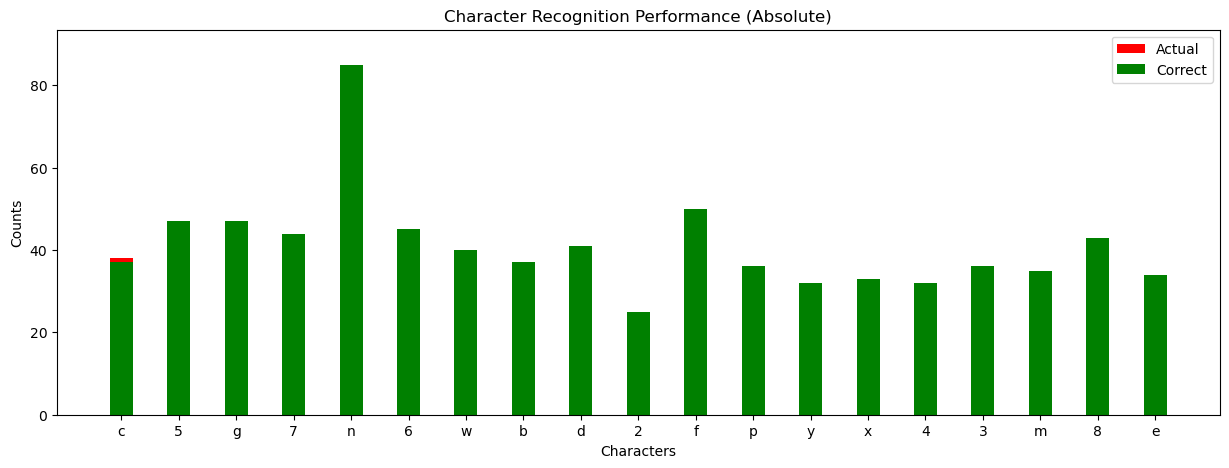

1/1 [==============================] - 0s 30ms/step


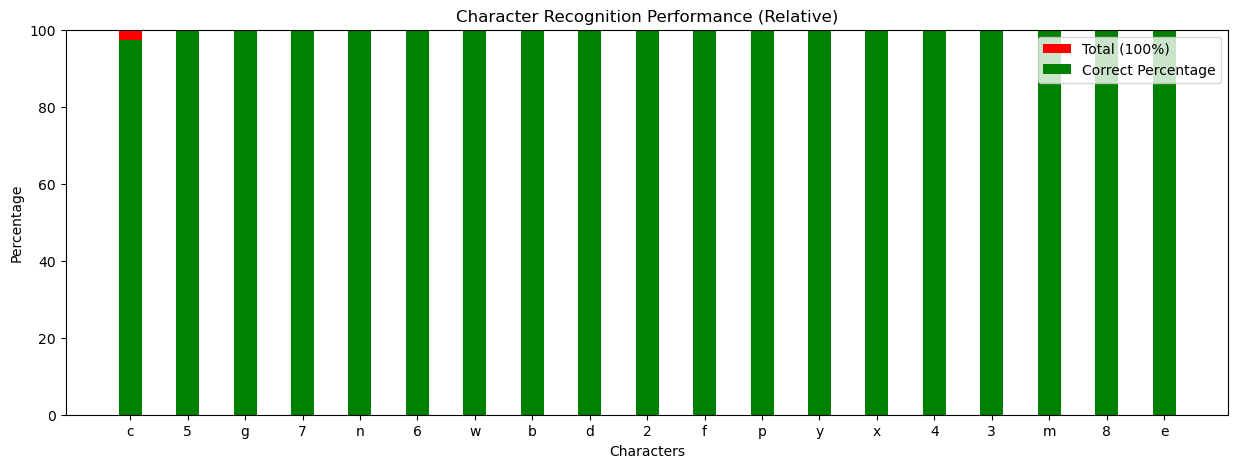

In [19]:
def plot_character_performance(self, plot_relative=False):
    character_counts = {}
    correct_character_counts = {}
    
    # A utility function to decode the output of the network
    def decode_batch_predictions(pred):
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :self.max_length]
        output_text = []
        for res in results:
            res = tf.strings.reduce_join(self.num_to_char(res)).numpy().decode("utf-8")
            output_text.append(res)
        return output_text

    def update_counts(pred, truth):
        for char in set(truth):
            character_counts[char] = character_counts.get(char, 0) + truth.count(char)
            correct_character_counts[char] = correct_character_counts.get(char, 0) + min(pred.count(char), truth.count(char))

    # Similar to the previous function, create prediction model and decode predictions
    prediction_model = keras.models.Model(
        self.model.get_layer(name="image").input, 
        self.model.get_layer(name="dense2").output
    )

    for batch in self.test_dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(len(pred_texts)):
            pred = pred_texts[i]
            truth = tf.strings.reduce_join(self.num_to_char(batch_labels[i])).numpy().decode("utf-8")
            update_counts(pred, truth)

    # Calculate error rates and sort characters based on it
    error_rates = {char: (character_counts[char] - correct_character_counts[char]) / character_counts[char]
                   if character_counts[char] > 0 else 0
                   for char in character_counts}
    sorted_characters = sorted(character_counts.keys(), key=lambda char: -error_rates[char])

    # Updated the plotting section to use sorted characters ordered from lowest predicted to highest
    sorted_actual_counts = [character_counts[char] for char in sorted_characters]
    sorted_correct_counts = [correct_character_counts[char] for char in sorted_characters]

    x = range(len(sorted_characters))
    plt.figure(figsize=(15, 5))

    if plot_relative:
        # Calculate relative performance (percentage)
        accuracies = [100 * (correct / actual) if actual > 0 else 0 for correct, actual in zip(sorted_correct_counts, sorted_actual_counts)]
        plt.bar(x, [100] * len(sorted_characters), width=0.4, color='red', label='Total (100%)', align='center')
        plt.bar(x, accuracies, width=0.4, color='green', label='Correct Percentage', align='center')
        plt.ylabel('Percentage')
    else:
        # Plot absolute performance
        plt.bar(x, sorted_actual_counts, width=0.4, color='red', label='Actual', align='center')
        plt.bar(x, sorted_correct_counts, width=0.4, color='green', label='Correct', align='center')
        plt.ylabel('Counts')

    plt.xlabel('Characters')
    plt.xticks(x, sorted_characters)
    plt.ylim(0, 100 if plot_relative else max(sorted_actual_counts) * 1.1)  # Adjust y-axis limit
    plt.legend()
    plt.title('Character Recognition Performance (Relative)' if plot_relative else 'Character Recognition Performance (Absolute)')
    plt.show()

DataSetHandler.plot_character_performance = plot_character_performance
# Example usage for absolute performance
data1.plot_character_performance(plot_relative=False)

# Example usage for relative performance
data1.plot_character_performance(plot_relative=True)

In [49]:
def count_characters_in_training(self):
    character_counts = {}

    # Iterate through all labels in the training dataset
    for label in self.y_train:
        # Assuming labels are stored as strings; otherwise, decode or convert them as needed
        for char in label:
            if char not in character_counts:
                character_counts[char] = 0
            character_counts[char] += 1

    # Sort the character counts from lowest to highest
    sorted_character_counts = sorted(character_counts.items(), key=lambda item: item[1])

    # Print the sorted character counts
    print("Characters frequency in training (sorted):")
    for char, count in sorted_character_counts:
        print(f"'{char}' occurred {count} times")

# Assign the updated function to the class
DataSetHandler.count_characters_in_training = count_characters_in_training

# Example usage
data1.count_characters_in_training()

Characters frequency in training (sorted):
'y' occurred 161 times
'w' occurred 163 times
'e' occurred 168 times
'b' occurred 168 times
'6' occurred 170 times
'p' occurred 172 times
'd' occurred 172 times
'f' occurred 175 times
'8' occurred 179 times
'7' occurred 182 times
'c' occurred 189 times
'x' occurred 190 times
'5' occurred 194 times
'm' occurred 194 times
'3' occurred 196 times
'g' occurred 197 times
'2' occurred 202 times
'4' occurred 207 times
'n' occurred 361 times


# saving model

In [32]:

model1.save(model_dir) 
plot_model(model1, to_file = "base_model/model_structure/base_model.png", dpi=80, show_shapes  = True, show_layer_names = True )


INFO:tensorflow:Assets written to: base_model\saved_model\assets


INFO:tensorflow:Assets written to: base_model\saved_model\assets


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Loading model

In [33]:

loaded_model = tf.keras.models.load_model(model_dir)

In [34]:
loaded_base_model = keras.models.Model(
    loaded_model.get_layer(name="image").input, loaded_model.get_layer(name="dense2").output
)
loaded_base_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            4921

# **Second dataset**

## process data and show example

Number of images found:  3016
Number of labels found:  3016
Number of unique characters:  51
Characters present:  ['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'h', 'j', 'k', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


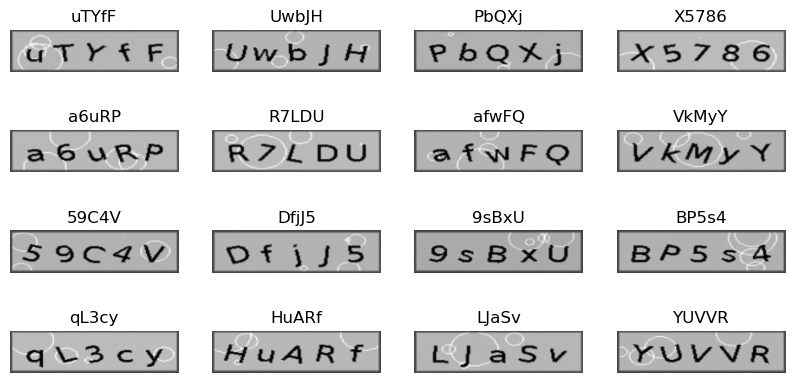

In [35]:
data2 = DataSetHandler(data_dir2)
data2.print_basics()
data2.split_data();
data2.process_dataset(invert_color = True);
data2.plot_examples()

In [36]:
print_dataset_sizes(data2)

Training Set Size: 2111
Validation Set Size: 453
Test Set Size: 452
Total Size: 3016


##  Building and training model with the same architecture as the base model

In [37]:
first_d2 = base_model_1(data2)
data2.model.summary()
data2.train_model(model = first_d2, epochs = d2_epochs)

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

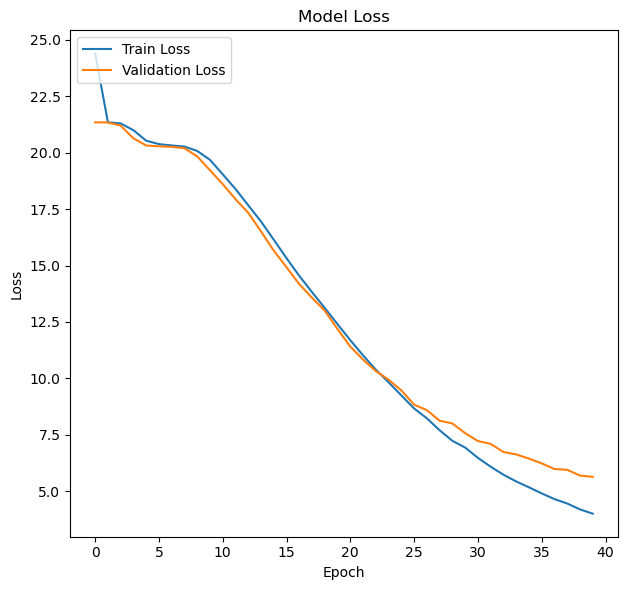

In [38]:
data2.plot_training_history()

1/1 [==============================] - 1s 819ms/step


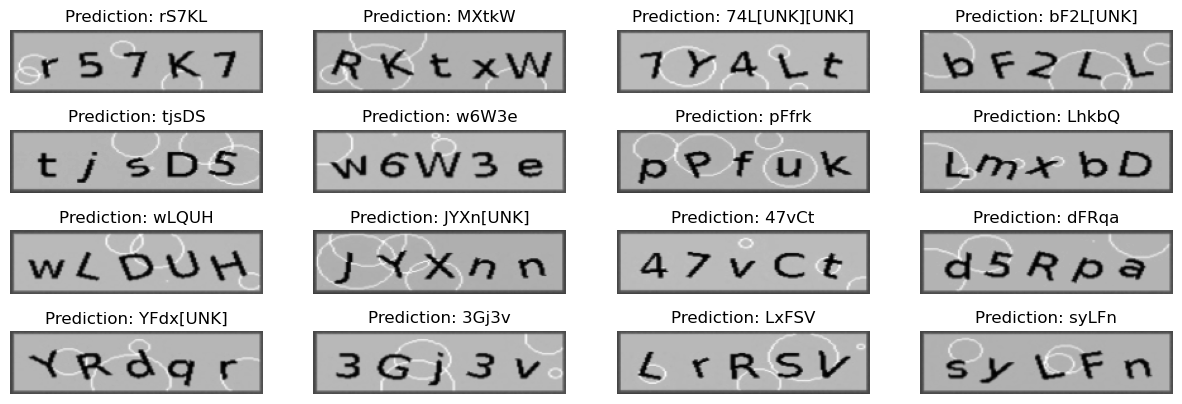

In [39]:
data2.make_predictions()

In [41]:
total_images, correct_images, img_accuracy = data2.evaluate_image_prediction_accuracy()
print(f"Total images: {total_images}")
print(f"Correct predictions: {correct_images}")
print(f"Image Prediction Accuracy: {img_accuracy:.4f}")

1/1 [==============================] - 0s 23ms/step
Total images: 452
Correct predictions: 51
Image Prediction Accuracy: 0.1128


1/1 [==============================] - 0s 20ms/step


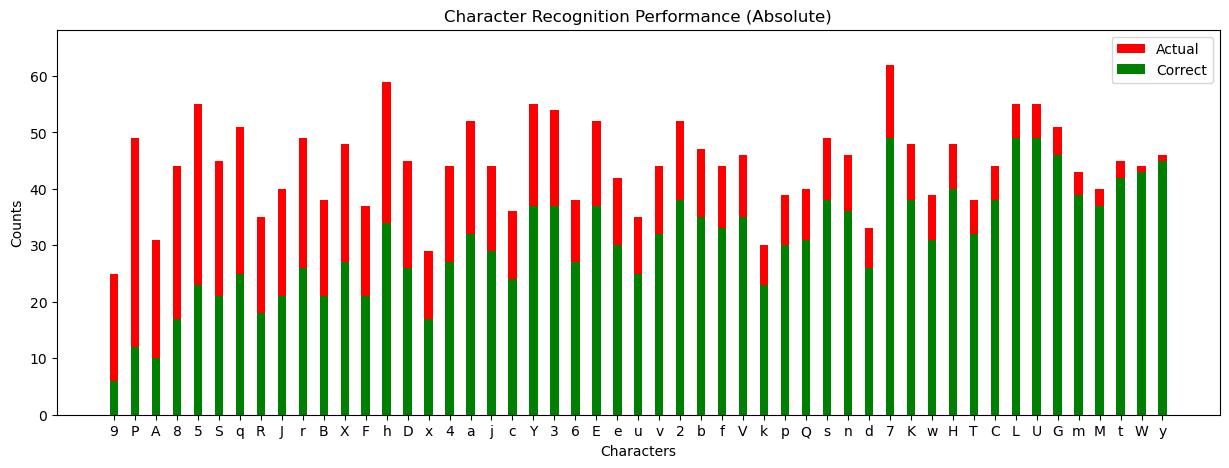

1/1 [==============================] - 0s 20ms/step


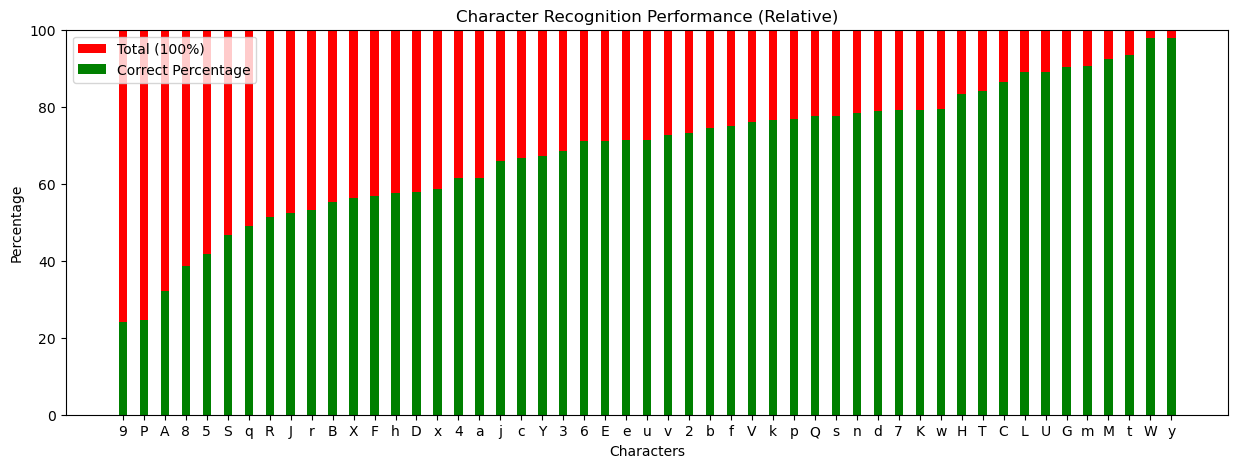

In [42]:
data2.plot_character_performance(plot_relative=False)
data2.plot_character_performance(plot_relative=True)

In [51]:
data2.count_characters_in_training()

Characters frequency in training (sorted):
'A' occurred 93 times
'9' occurred 100 times
'D' occurred 177 times
'V' occurred 188 times
'a' occurred 190 times
'u' occurred 195 times
'w' occurred 196 times
'S' occurred 197 times
'Y' occurred 200 times
'4' occurred 200 times
'G' occurred 200 times
'U' occurred 201 times
'K' occurred 201 times
'f' occurred 202 times
'Q' occurred 203 times
'L' occurred 204 times
'k' occurred 204 times
'h' occurred 206 times
'p' occurred 206 times
'5' occurred 207 times
'd' occurred 207 times
'P' occurred 208 times
'q' occurred 208 times
'm' occurred 208 times
'R' occurred 210 times
't' occurred 210 times
'W' occurred 210 times
'C' occurred 212 times
'v' occurred 212 times
'y' occurred 214 times
'J' occurred 215 times
'r' occurred 215 times
'2' occurred 215 times
'c' occurred 217 times
'T' occurred 218 times
'7' occurred 219 times
'F' occurred 220 times
'b' occurred 221 times
'x' occurred 221 times
'3' occurred 221 times
'B' occurred 223 times
'8' occurred 22

# Defining the second model which uses transfer learning

In [52]:
def second_model(self, base_model = None):
    # Inputs to the model
    input_img = layers.Input(
        shape=(self.img_width, self.img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
    base_model = keras.models.clone_model(base_model)
    base = keras.models.Model(
        base_model.get_layer(name="Conv1").input, base_model.get_layer(name="bidirectional1").output
        ,  name = "base_model"
    )
    # base.trainable = False
    x = base(input_img)
    # x = base(input_img, training = False)
    
    
    
     # Output layer
    x = layers.Dense(
        len(self.char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)
    
    
    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)
    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    self.model = model
    return model

# Using the base model trained with the first dataset

In [53]:
model2 = second_model(data2, base_model = loaded_base_model);
model2.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 base_model (Functional)     (None, 50, 256)              265664    ['image[0][0]']               
                                                                                                  
 label (InputLayer)          [(None, None)]               0         []                            
                                                                                                  
 dense2 (Dense)              (None, 50, 53)               13621     ['base_model[0][0]']          
                                                                                       

In [54]:
data2.train_model(epochs = d2_epochs, model = model2)

Epoch 1/40
132/132 [==============================] - 14s 89ms/step - loss: 24.8928 - val_loss: 21.7345
Epoch 2/40
132/132 [==============================] - 11s 86ms/step - loss: 21.3831 - val_loss: 21.6176
Epoch 3/40
132/132 [==============================] - 12s 88ms/step - loss: 21.3704 - val_loss: 21.6234
Epoch 4/40
132/132 [==============================] - 11s 86ms/step - loss: 21.3424 - val_loss: 21.4783
Epoch 5/40
132/132 [==============================] - 11s 86ms/step - loss: 21.2833 - val_loss: 21.3642
Epoch 6/40
132/132 [==============================] - 11s 87ms/step - loss: 21.0214 - val_loss: 20.7403
Epoch 7/40
132/132 [==============================] - 11s 86ms/step - loss: 20.6969 - val_loss: 20.5810
Epoch 8/40
132/132 [==============================] - 12s 88ms/step - loss: 20.3479 - val_loss: 20.1513
Epoch 9/40
132/132 [==============================] - 12s 89ms/step - loss: 19.8963 - val_loss: 19.7947
Epoch 10/40
132/132 [==============================] - 11s 87ms/

## Making predictions

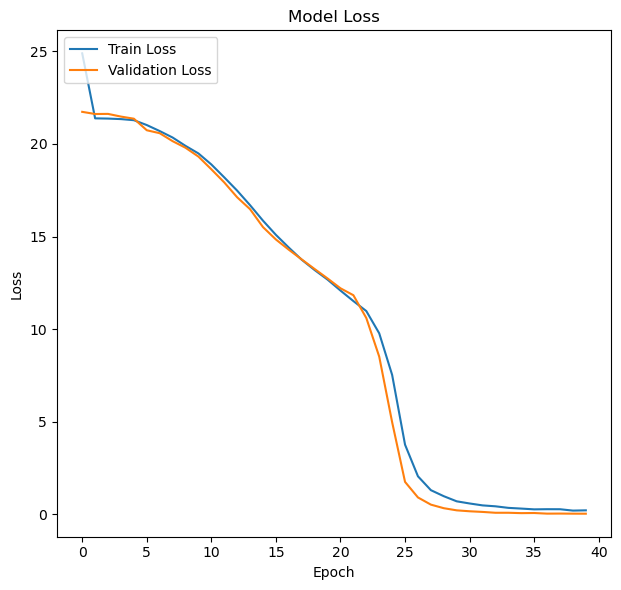

In [55]:
data2.plot_training_history()

1/1 [==============================] - 1s 612ms/step


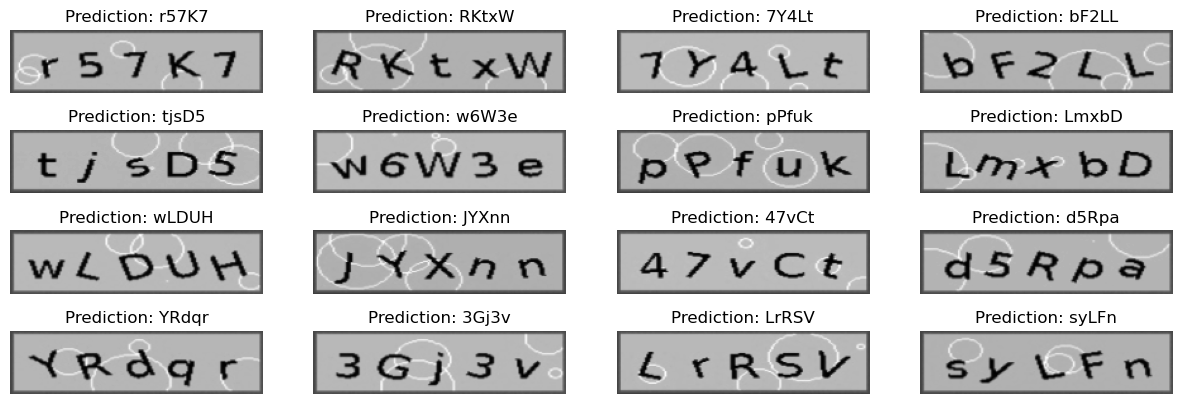

In [56]:
data2.make_predictions()

In [57]:
total_images, correct_images, img_accuracy = data2.evaluate_image_prediction_accuracy()
print(f"Total images: {total_images}")
print(f"Correct predictions: {correct_images}")
print(f"Image Prediction Accuracy: {img_accuracy:.4f}")

1/1 [==============================] - 0s 27ms/step
Total images: 452
Correct predictions: 450
Image Prediction Accuracy: 0.9956


1/1 [==============================] - 0s 29ms/step


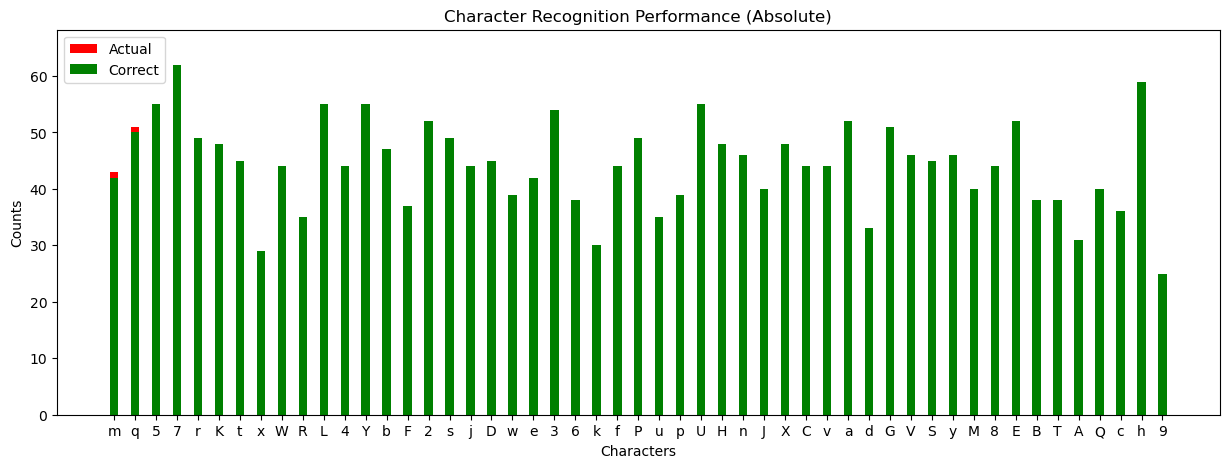

1/1 [==============================] - 0s 25ms/step


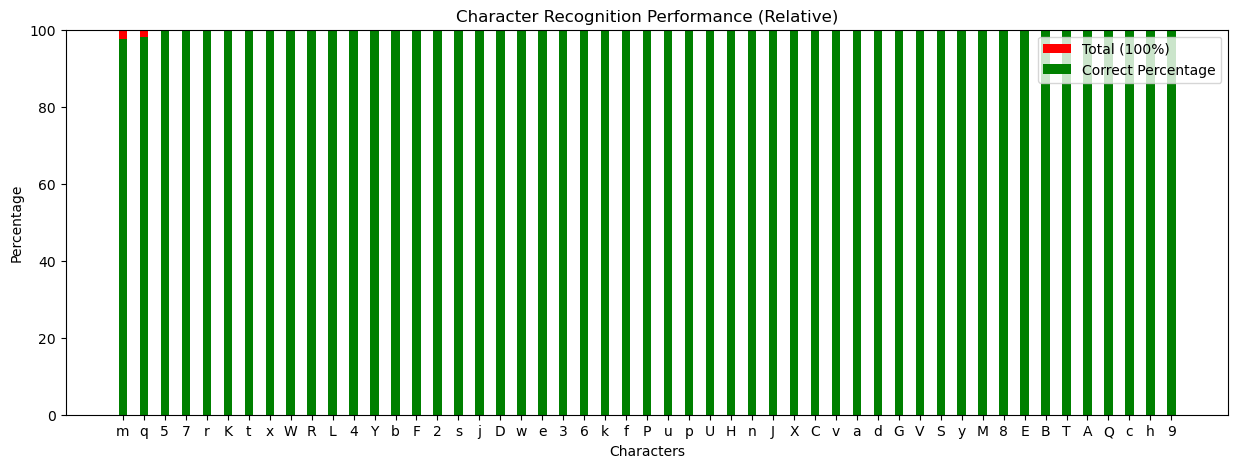

In [58]:
data2.plot_character_performance(plot_relative=False)
data2.plot_character_performance(plot_relative=True)

In [59]:
data2.count_characters_in_training()

Characters frequency in training (sorted):
'A' occurred 93 times
'9' occurred 100 times
'D' occurred 177 times
'V' occurred 188 times
'a' occurred 190 times
'u' occurred 195 times
'w' occurred 196 times
'S' occurred 197 times
'Y' occurred 200 times
'4' occurred 200 times
'G' occurred 200 times
'U' occurred 201 times
'K' occurred 201 times
'f' occurred 202 times
'Q' occurred 203 times
'L' occurred 204 times
'k' occurred 204 times
'h' occurred 206 times
'p' occurred 206 times
'5' occurred 207 times
'd' occurred 207 times
'P' occurred 208 times
'q' occurred 208 times
'm' occurred 208 times
'R' occurred 210 times
't' occurred 210 times
'W' occurred 210 times
'C' occurred 212 times
'v' occurred 212 times
'y' occurred 214 times
'J' occurred 215 times
'r' occurred 215 times
'2' occurred 215 times
'c' occurred 217 times
'T' occurred 218 times
'7' occurred 219 times
'F' occurred 220 times
'b' occurred 221 times
'x' occurred 221 times
'3' occurred 221 times
'B' occurred 223 times
'8' occurred 22